**INTRODUCTION**

This Kaggle competition "I'm Something of a Painter Myself" involves generating Monet-style images using Generative Adversarial Networks (GANs). 

The goal is to create a model that can generate high-quality images that mimic the artistic style of Claude Monet paintings.

The images generated, between 7000 and 10000, should be in JPEG format, sized 256x256 pixels with 3 color channels. 

The quality of the generated images will be evaluated based on the metric MiFID (Memorization-informed Fréchet Inception Distance).

This report includes data preparation, model building and hyperparameter tuning using TensorFlow and Optuna.

8000 Monet_style images will be generated by the model and saved in a zip file for submission.

**Importing libraries**

In [ ]:
import optuna
import tensorflow as tf
import zipfile
import os
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import warnings
import numpy as np

**Hyperparameters for the model and image processing**

In [ ]:

img_height = 256
img_width = 256
img_channels = 3
batch_size = 40
total_epochs = 300
num_images = 8000
sample_images = 4
interval_epochs = 100
output_zip = "images.zip"
sample_transformation = 5
n_trials = 10

warnings.simplefilter(action ="ignore", category = FutureWarning)

**Model architecture - Generator**

In [ ]:
best_generator_g = None
best_loss = float("inf")

def build_generator():
    
    inputs = layers.Input(shape=[img_height, img_width, img_channels])
    x = layers.Conv2D(64, 4, strides=2, padding="same")(inputs)
    x = layers.LeakyReLU()(x)
    
    x = layers.Conv2D(128, 4, strides=2, padding="same")(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2DTranspose(64, 4, strides=2, padding="same")(x)
    x = layers.LeakyReLU()(x)
    
    x = layers.Conv2DTranspose(img_channels, 4, strides=2, padding="same", activation="tanh")(x)

    model = tf.keras.Model(inputs=inputs, outputs=x)
    
    return model

**Model architecture - Discriminator**

In [ ]:
def build_discriminator():
    
    inputs = layers.Input(shape=[img_height, img_width, img_channels])
    x = layers.Conv2D(64, 4, strides=2, padding="same")(inputs)
    x = layers.LeakyReLU()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(1)(x)

    model = tf.keras.Model(inputs=inputs, outputs=x)
    
    return model

**Loss functions**

In [ ]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = loss_object(tf.ones_like(real_output), real_output)
    fake_loss = loss_object(tf.zeros_like(fake_output), fake_output)
    return (real_loss + fake_loss) * 0.5

def generator_loss(fake_output):
    return loss_object(tf.ones_like(fake_output), fake_output)

def cycle_consistency_loss(real_image, cycled_image, lambda_cycle=10):
    return lambda_cycle * tf.reduce_mean(tf.abs(real_image - cycled_image))

def identity_loss(real_image, same_image, lambda_identity=5):
    return lambda_identity * tf.reduce_mean(tf.abs(real_image - same_image))

**Data preprocessing functions**

In [ ]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [img_height, img_width])
    image = (image / 127.5) - 1
    return image

def prepare_data(photo_folder, monet_folder):
    photo_files = [os.path.join(photo_folder, img) for img in os.listdir(photo_folder) if img.endswith(".jpg")]
    monet_files = [os.path.join(monet_folder, img) for img in os.listdir(monet_folder) if img.endswith(".jpg")]

    photo_dataset = tf.data.Dataset.from_tensor_slices(photo_files).map(load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size)
    monet_dataset = tf.data.Dataset.from_tensor_slices(monet_files).map(load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size)

    dataset = tf.data.Dataset.zip((photo_dataset, monet_dataset)).prefetch(tf.data.AUTOTUNE)
    return dataset

**Sample photos from dataset**

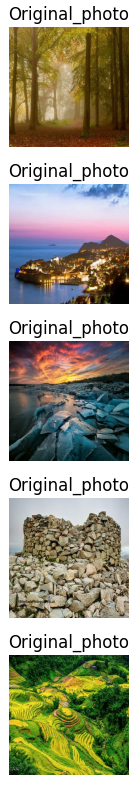

**Visualization for transformation steps**

The function displays intermediate transformation steps for generated Monet-style images. 

We can visualize below how the model processes photos at various steps of the training.

In [ ]:
def display_transformation_steps(generator_g, dataset, sample_transformation):
    photo_batch, _ = next(iter(dataset.take(1)))

    plt.figure(figsize=(20, 8))
    for i in range(sample_transformation):
        if i >= photo_batch.shape[0]:
            break  
        
        plt.subplot(sample_transformation, 6, i * 6 + 1)  
        plt.imshow((photo_batch[i] + 1) / 2)
        plt.title("Original_photo")
        plt.axis("off")

        fake_monet = generator_g(photo_batch[i:i+1], training=False)

        plt.subplot(sample_transformation, 6, i * 6 + 2)
        plt.imshow((fake_monet[0] + 1) / 2)
        plt.title("Training_step 1")
        plt.axis("off")

        for step in range(2, 5):
            fake_monet = generator_g(fake_monet, training=False)
            plt.subplot(sample_transformation, 6, i * 6 + step + 1)  
            plt.imshow((fake_monet[0] + 1) / 2)
            plt.title(f"Training_step {step}")
            plt.axis("off")

        plt.subplot(sample_transformation, 6, i * 6 + 6)
        plt.imshow((fake_monet[0] + 1) / 2)
        plt.title("Monet_style")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

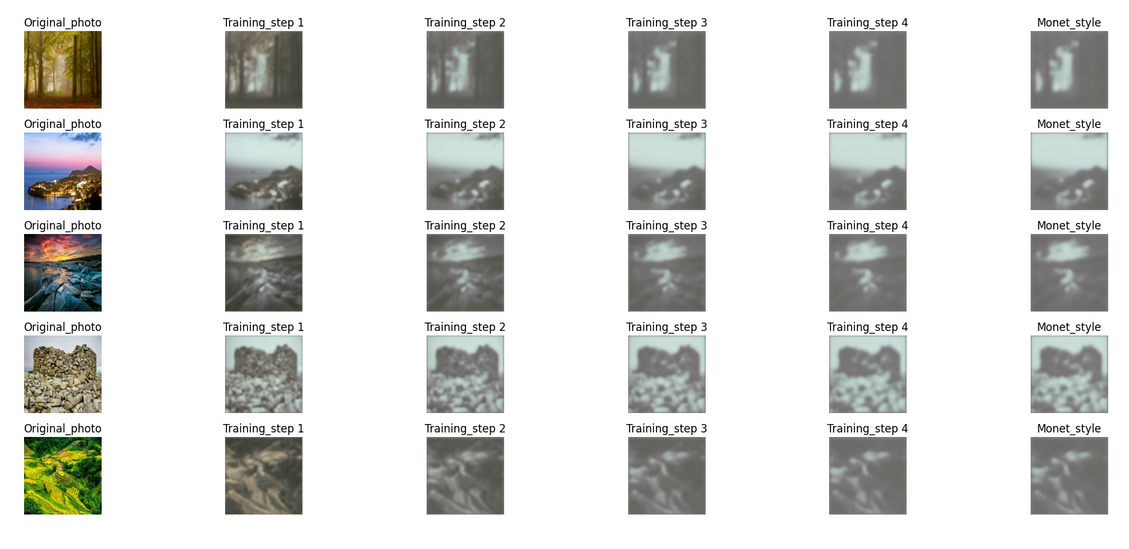

**Save and display generated images**

These functions save generated images to a zip file and display a sample of them.

In [ ]:
def save_images_to_zip(zip_filename, images):
    with zipfile.ZipFile(zip_filename, 'w') as zipf:
        for i, img in enumerate(images):
            img = (img + 1.0) * 127.5
            img = tf.cast(img, tf.uint8)
            img_pil = tf.keras.preprocessing.image.array_to_img(img)
            image_filename = f"image_{i}.jpg"
            img_pil.save(image_filename, format='JPEG')
            zipf.write(image_filename)
            os.remove(image_filename) 

def save_and_display_generated_images(generator_g, dataset, epoch, sample_images):
    photo_batch = next(iter(dataset.shuffle(buffer_size=1000).map(lambda x, _: x).take(1)))
    generated_images = generator_g(photo_batch, training=False)
    
    plt.figure(figsize=(20, 10))
    for i in range(sample_images):
        if i >= generated_images.shape[0]:
            break  
        plt.subplot(1, sample_images, i + 1)
        plt.imshow((generated_images[i] + 1) / 2)
        plt.axis("off")
    plt.suptitle(f'Generated Images at Epoch {epoch + 1}')
    plt.show()
    
    return generated_images 

**Sample of generated images**

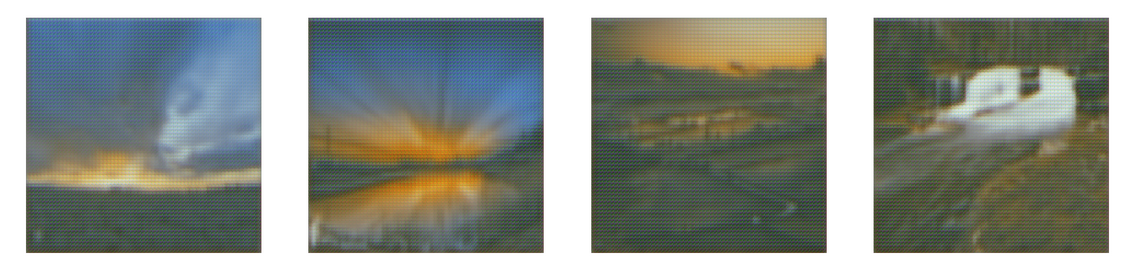

**Data path**

In [ ]:
photo_folder = "/kaggle/input/gan-getting-started/photo_jpg"
monet_folder = "/kaggle/input/gan-getting-started/monet_jpg"
dataset = prepare_data(photo_folder, monet_folder)

**Hyperparameter tuning with Optuna**

I chose Optuna to optimize key hyperparameters such as regularization factors (cycle-consistency, identity loss weights) and learning rate.

Optuna is great for this GAN task because it efficiently automates hyperparameter tuning and can improve model performance for a faster convergence.

Documentation on Optuna can be found here *" https://optuna.org/ "*

In [ ]:
def objective(trial):

    global best_generator_g
    global best_loss

    lambda_cycle = trial.suggest_loguniform("lambda_cycle", 1, 20)
    lambda_identity = trial.suggest_loguniform("lambda_identity", 1, 20)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-7, 1e-3)

    generator_g = build_generator()
    generator_f = build_generator()
    discriminator_x = build_discriminator()
    discriminator_y = build_discriminator()

    generator_g_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.5)
    generator_f_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.5)
    discriminator_x_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.5)
    discriminator_y_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.5)
    
    generator_g.summary()

    @tf.function
    def train_step(real_photo, real_monet):
        with tf.GradientTape(persistent=True) as tape:
            fake_monet = generator_g(real_photo, training=True)
            fake_photo = generator_f(real_monet, training=True)

            cycled_photo = generator_f(fake_monet, training=True)
            cycled_monet = generator_g(fake_photo, training=True)

            same_photo = generator_f(real_photo, training=True)
            same_monet = generator_g(real_monet, training=True)

            disc_real_photo = discriminator_x(real_photo, training=True)
            disc_real_monet = discriminator_y(real_monet, training=True)
            disc_fake_photo = discriminator_x(fake_photo, training=True)
            disc_fake_monet = discriminator_y(fake_monet, training=True)

            gen_g_loss = generator_loss(disc_fake_monet)
            gen_f_loss = generator_loss(disc_fake_photo)

            cycle_loss_g = cycle_consistency_loss(real_photo, cycled_photo, lambda_cycle)
            cycle_loss_f = cycle_consistency_loss(real_monet, cycled_monet, lambda_cycle)

            total_gen_g_loss = gen_g_loss + cycle_loss_g + identity_loss(real_monet, same_monet, lambda_identity)
            total_gen_f_loss = gen_f_loss + cycle_loss_f + identity_loss(real_photo, same_photo, lambda_identity)

            disc_x_loss = discriminator_loss(disc_real_photo, disc_fake_photo)
            disc_y_loss = discriminator_loss(disc_real_monet, disc_fake_monet)

        generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
        generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)

        discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
        discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)

        generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
        generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))

        discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
        discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))

        return total_gen_g_loss, total_gen_f_loss, disc_x_loss, disc_y_loss

    for epoch in range(total_epochs):
        epoch_gen_g_loss = 0
        epoch_gen_f_loss = 0
        epoch_disc_x_loss = 0
        epoch_disc_y_loss = 0
        num_batches = 0

        for real_photo, real_monet in dataset:
            gen_g_loss, gen_f_loss, disc_x_loss, disc_y_loss = train_step(real_photo, real_monet)
            epoch_gen_g_loss += gen_g_loss
            epoch_gen_f_loss += gen_f_loss
            epoch_disc_x_loss += disc_x_loss
            epoch_disc_y_loss += disc_y_loss
            num_batches += 1

        avg_gen_g_loss = epoch_gen_g_loss / num_batches
        avg_gen_f_loss = epoch_gen_f_loss / num_batches
        avg_disc_x_loss = epoch_disc_x_loss / num_batches
        avg_disc_y_loss = epoch_disc_y_loss / num_batches

        if (epoch + 1) % interval_epochs == 0:
            print(f"Trial {trial.number} | Epoch: {epoch + 1}/{total_epochs}")
            print(f"  Generator G Loss: {avg_gen_g_loss.numpy():.4f}")
            print(f"  Generator F Loss: {avg_gen_f_loss.numpy():.4f}")
            print(f"  Discriminator X Loss: {avg_disc_x_loss.numpy():.4f}")
            print(f"  Discriminator Y Loss: {avg_disc_y_loss.numpy():.4f}")

            generated_images = save_and_display_generated_images(generator_g, dataset, epoch, sample_images)

            if epoch == total_epochs - 1:
                save_images_to_zip(output_zip, generated_images[:num_images]) 

    current_loss = avg_gen_g_loss.numpy() + avg_gen_f_loss.numpy()  
    if current_loss < best_loss:
        best_loss = current_loss
        best_generator_g = build_generator()
        best_generator_g.set_weights(generator_g.get_weights())

    display_transformation_steps(best_generator_g, dataset, sample_transformation)

    return best_loss 

study = optuna.create_study(direction = "minimize", study_name = "Monet_gan_hp_optimization")
study.optimize(objective, n_trials = n_trials )

print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

**Generating and saving 8000 Monet-style images**

In [ ]:

if best_generator_g is not None:
    num_batches = num_images // batch_size  
    generated_images = []

    for _ in range(num_batches):
        photo_batch = next(iter(dataset.shuffle(buffer_size = 1000).map(lambda x, _: x).take(1)))
        generated_batch = best_generator_g(photo_batch, training=False)
        generated_images.append(generated_batch)

    generated_images = tf.concat(generated_images, axis=0)

    save_images_to_zip(output_zip, generated_images[:num_images]) 
    print(f"Generated {num_images} Monet_style images saved to {output_zip}.")
else:
    print("Check the training process.")

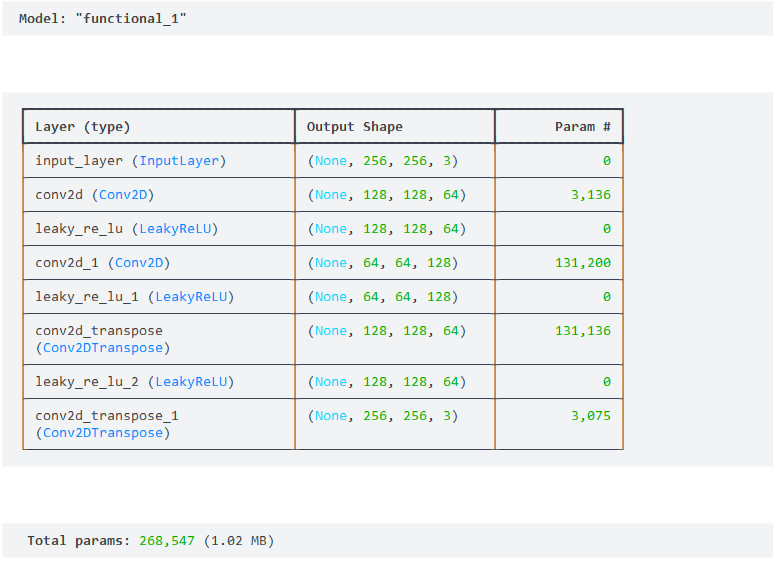

**A few visualizations of sample images printed during training**

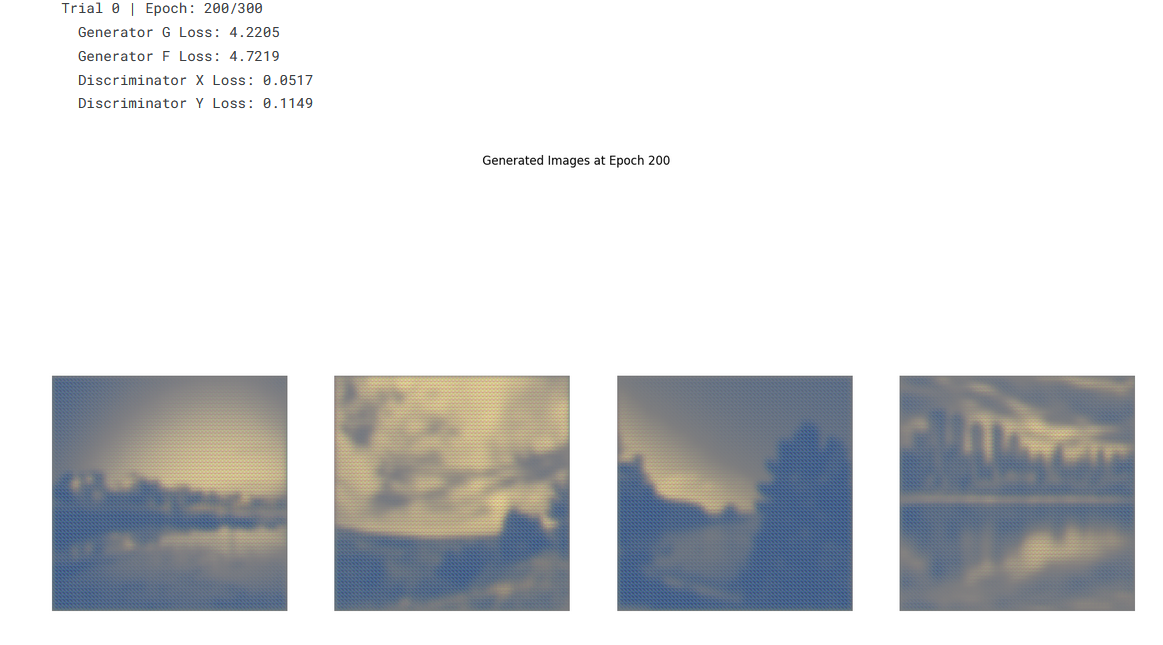

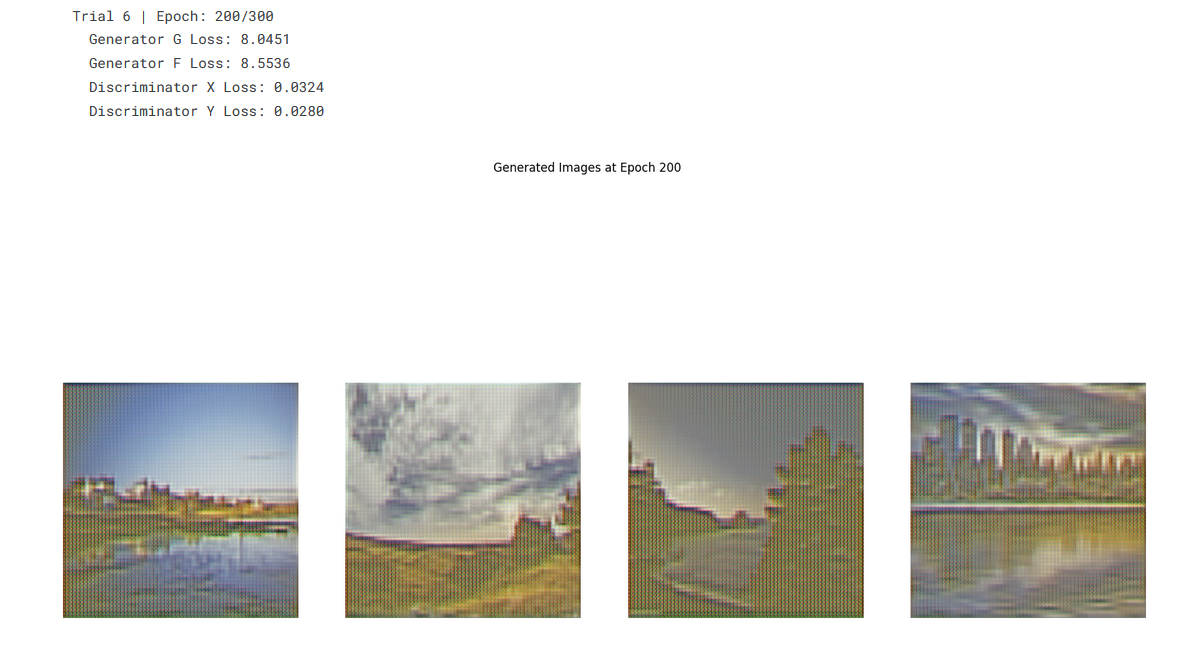

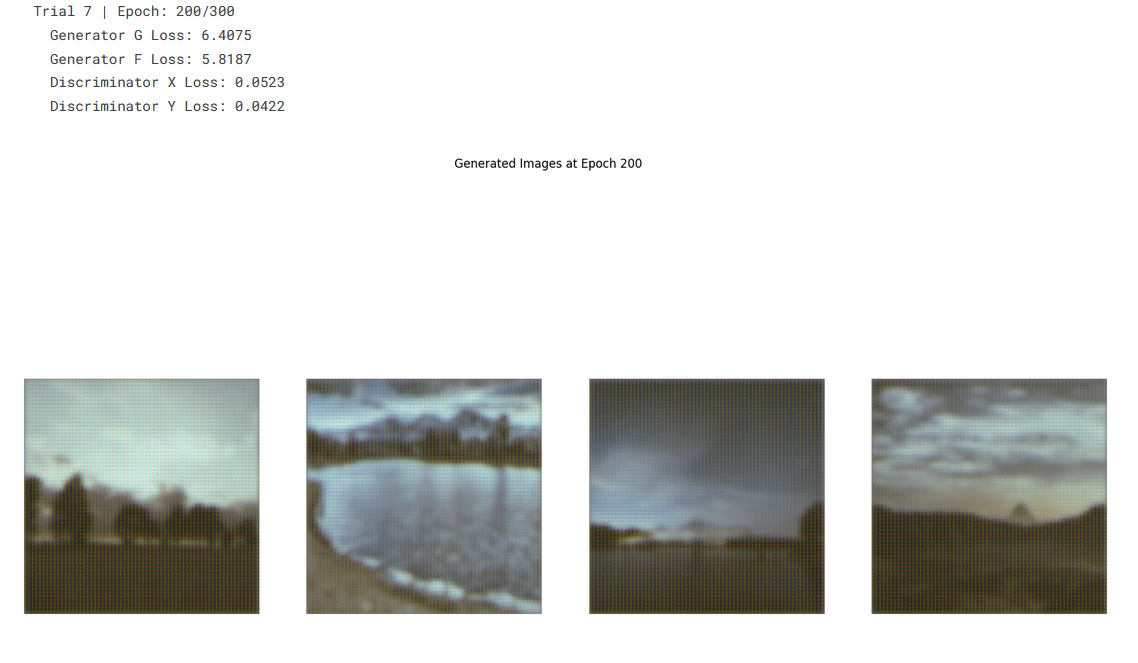

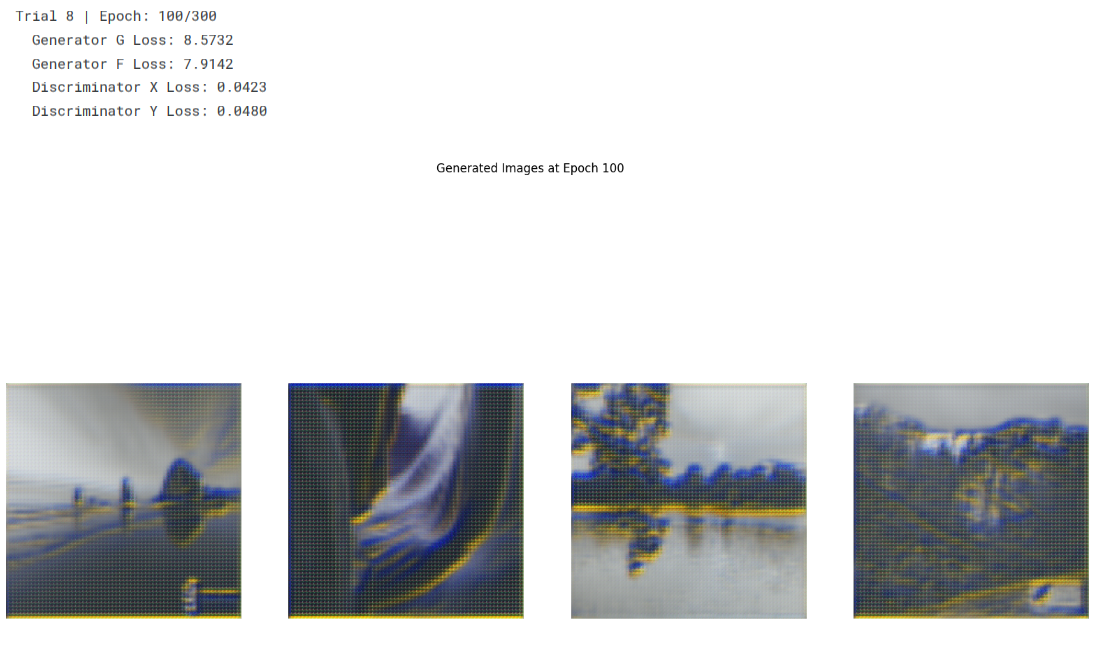

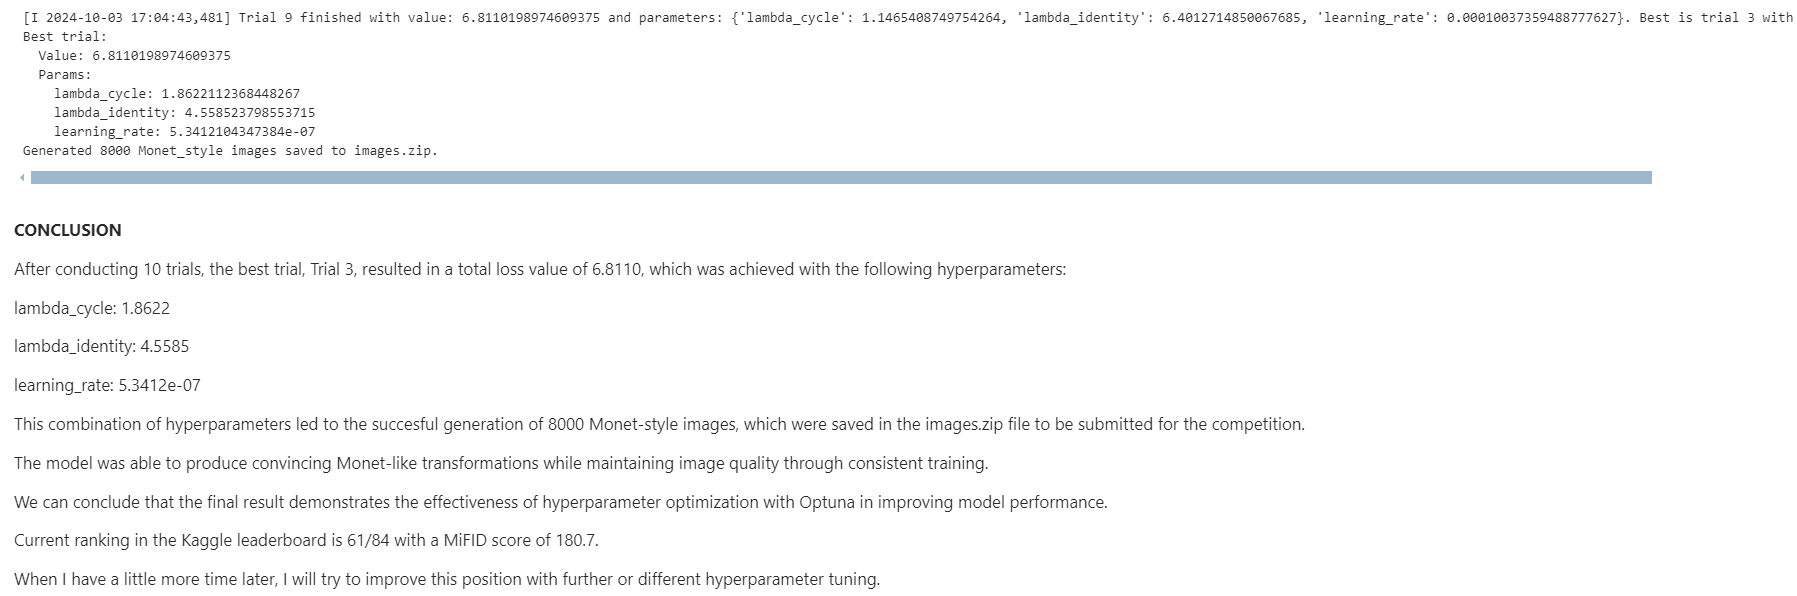

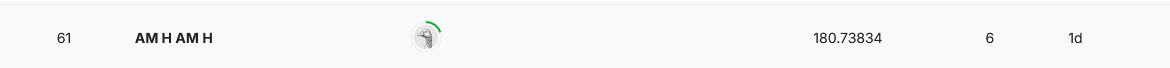